In [1]:
# импортируйте нужные библиотеки
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
import scipy as sp
import scipy.stats as stats
import sklearn as sk
import plotly.figure_factory as ff
import plotly as py
import plotly.graph_objs as go
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from IPython.display import Image

pio.renderers.default = 'iframe'
pio.templates.default = 'plotly'
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [2]:
# сгенерируйте линейно разделимую выборку для задачи бинарной классификации
iris = load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
y[y == 0] = -1

data = pd.DataFrame(data = X, columns=['Sepal length', 'Sepal width'])
data['Species'] = y
data = data[data['Species'] != 2]
data

,Sepal length,Sepal width,Species
0,5.1,3.5,-1
1,4.9,3.0,-1
2,4.7,3.2,-1
3,4.6,3.1,-1
4,5.0,3.6,-1
...,...,...,...
95,5.7,3.0,1
96,5.7,2.9,1
97,6.2,2.9,1
98,5.1,2.5,1


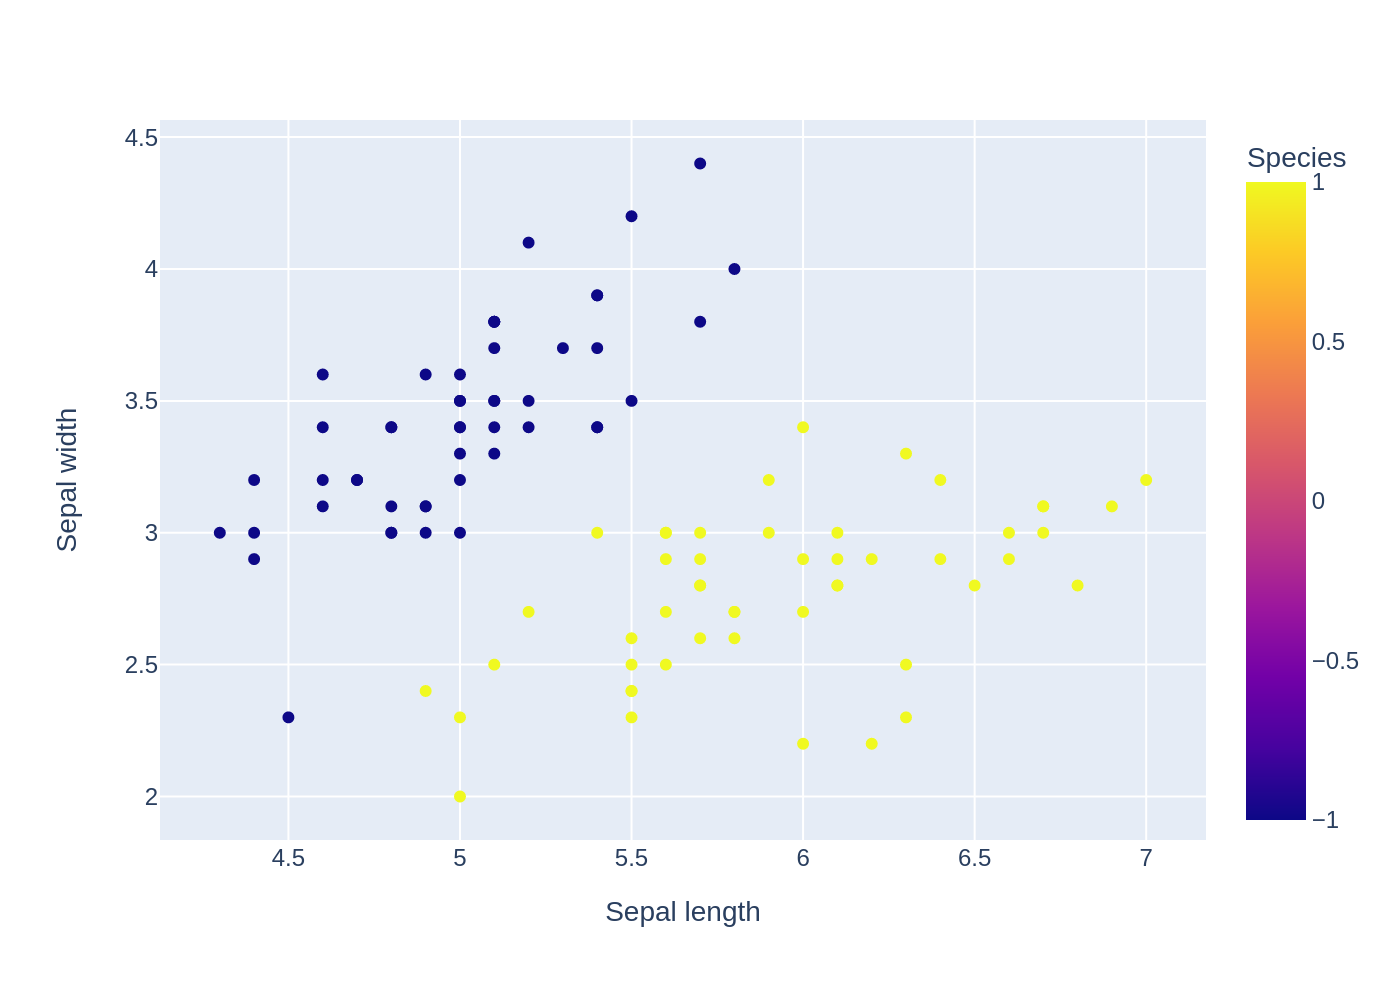

In [3]:
fig = px.scatter(data, x = 'Sepal length', y = 'Sepal width', color= 'Species')
img_bytes = fig.to_image(format = 'png', scale = 2)
Image(img_bytes)

In [4]:
X = data.iloc[:, :2].to_numpy()
y = data.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

# Логистическая регрессия

Конечным результатом задачи классификации является разбиение множества объектов на классы. Давайте усложним задачу и будем предсказывать не конкретные классы, а вероятности принадлежать им, например, для бинарной классификации мы будем предсказывать одно число, которое будет соответствовать вероятности принадлежать положительному классу. \
Такого результата можно достичь, если мы будем строить линейную регрессию над некоторыми признаками, а затем её результат переводить в отрезок $[0;1]$. В этом нам поможет сигмоидная функция, которая имеет вид:
<p style="text-align: center;"> $f(z) = \dfrac{1}{1 + e^{-z}}$ </p>

![sigmoid.webp](https://cmertin.github.io/images/2016/11/11_17-Loan_Approvals/Sigmoid_Function.png)
<p style="text-align: center;"></p>

Моделью логистической регрессии назовём функцию от весов и объекта вида:

<p style="text-align: center;"> $a(w, x) = \dfrac{1}{1 + e^{-w_0 - w_1x_1 + ... + w_mx_m}}$ </p>

Обучение данной модели происходит за счет кросс-энтропийной или логистической функции потерь :
<p style="text-align: center;"> $-\sum\limits_{i=1}^{n}(y_ilog(a_i) + (1 - y_i)log(1 - a_i))$ </p>
где $a_i = a(w, x_i)$

Я буду обучать логистическую регрессию на метках из $\{1, -1\}$, а не ($\{0, 1\}$), поэтому общая функция потерь у меня будет отличаться. Прилагаю вывод функции потерь, использующейся для классификации на метках $\{-1, 1\}$.

Kevin P. Murphy - Probabilistic Machine Learning An Introduction-The MIT Press (2022) (Draft Edition), page 336.

Формула $(10.6)$ это вывод кросс-энтропийной функции потерь, а формула $(10.11)$ -- вывод функции потерь, если метки у нас из $\{-1, 1\}$.

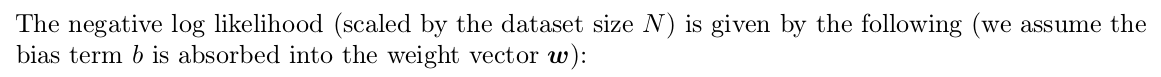

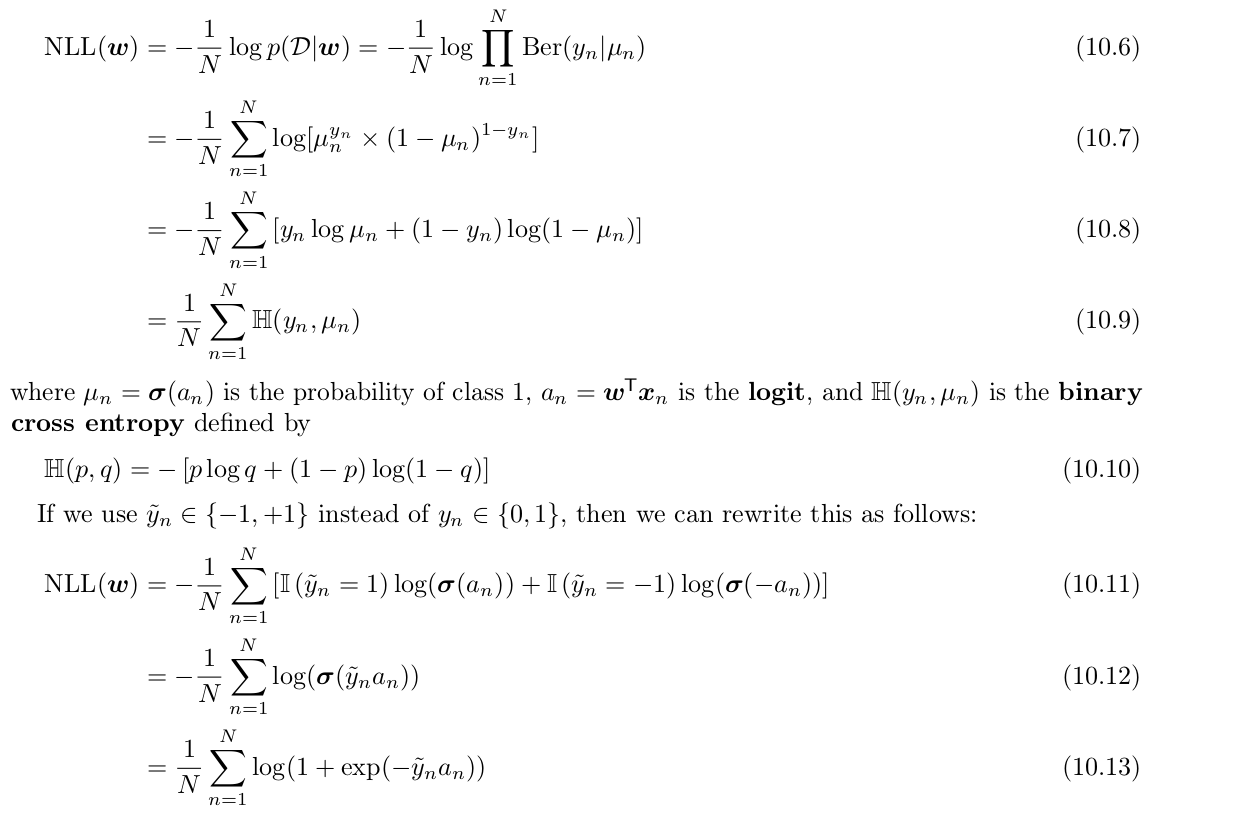

#### Задание №1. Выведите шаг градиентного спуска для логистической функции потерь (приложить фото)

<font size = 5>Я разобрал вывод градиента как для функции потерь для меток из $\{-1,1\}$, так и для меток из $\{0,1\}$ (используя правда немного другие обозначения). Начнём с градиента в случае меток из $\{-1,1\}$.</font>

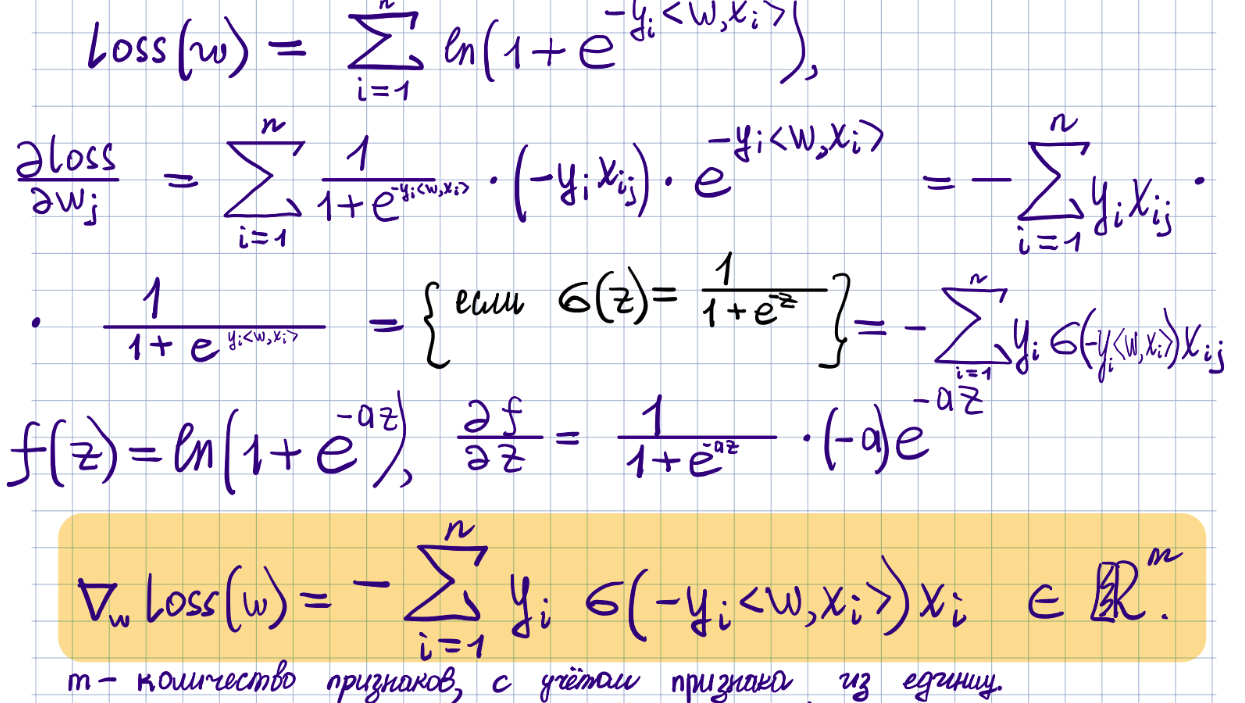

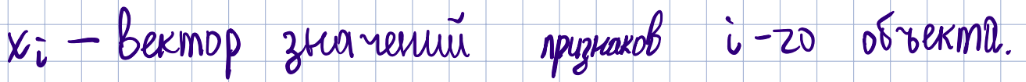

В теле функции нахождения градиента я дословно реализую приведённую выше формулу, с использованием векторизации.
В частности, с помощью ```y[..., np.newaxis]``` я вектор строку превращаю в вектор столбец всюду, где это необходимо для правильного выполнения операций над векторами.

<font size = 5>А теперь вывод градиента в случае меток $\{0,1\}$. Я также реализовал подсчёт градиента в обоих случаях, исключительно из интереса.</font>

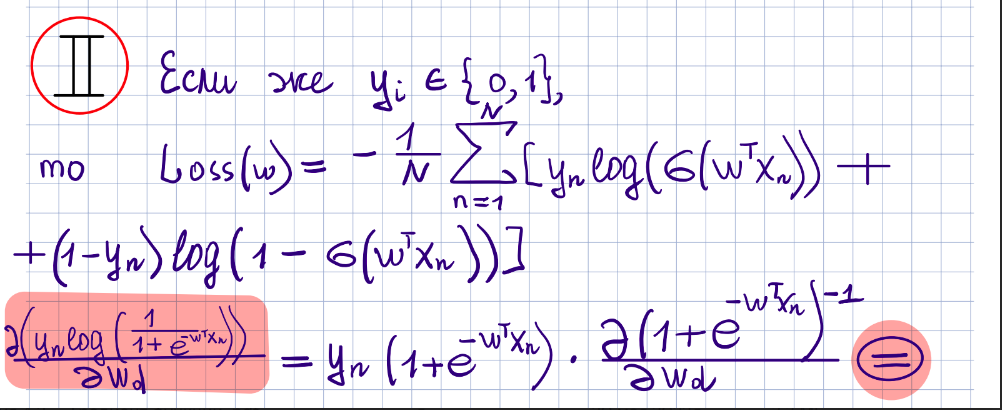

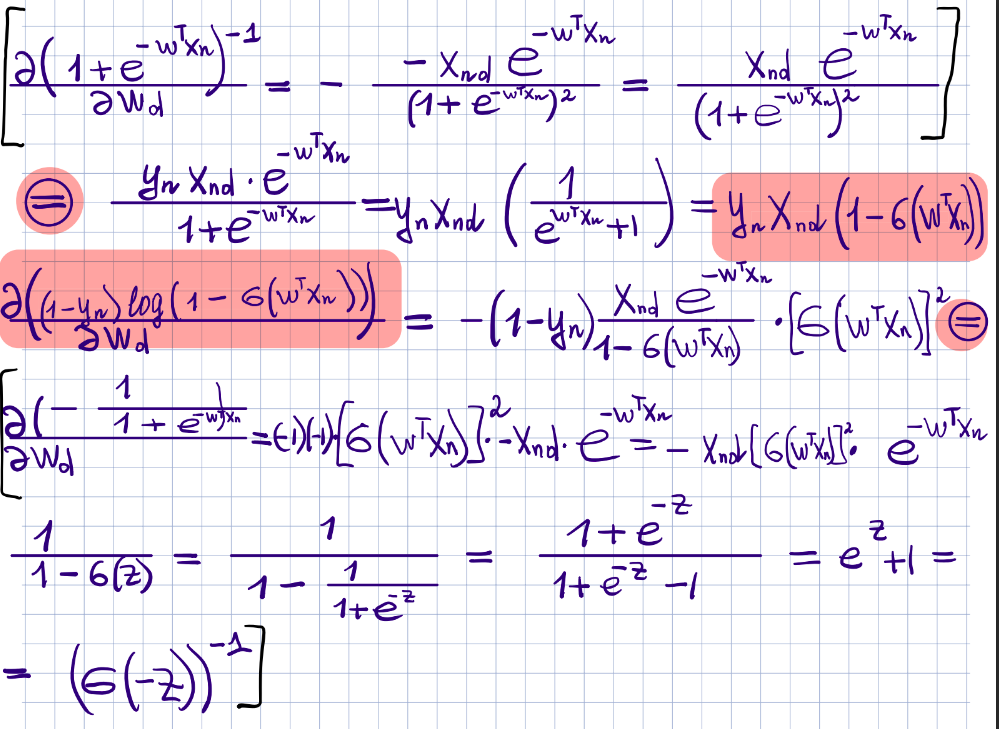

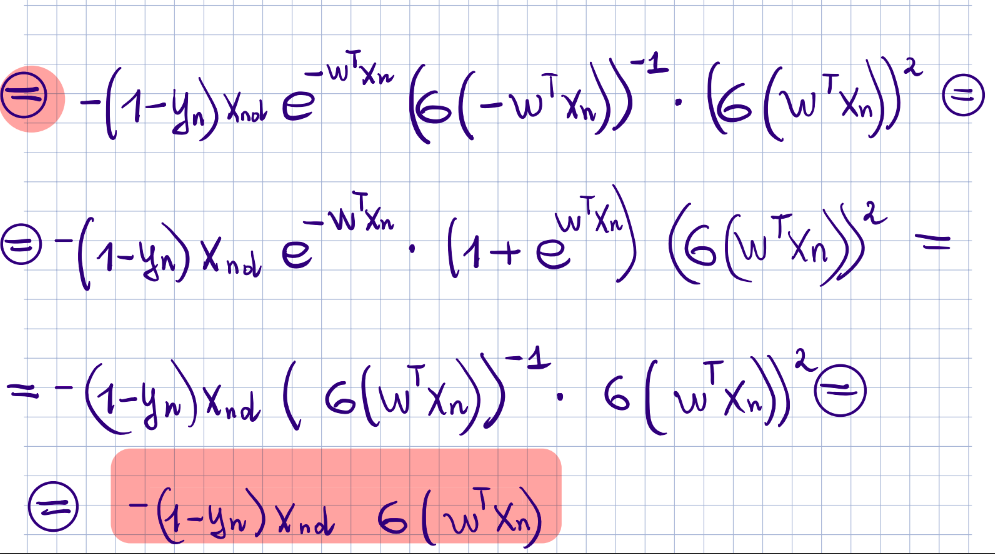

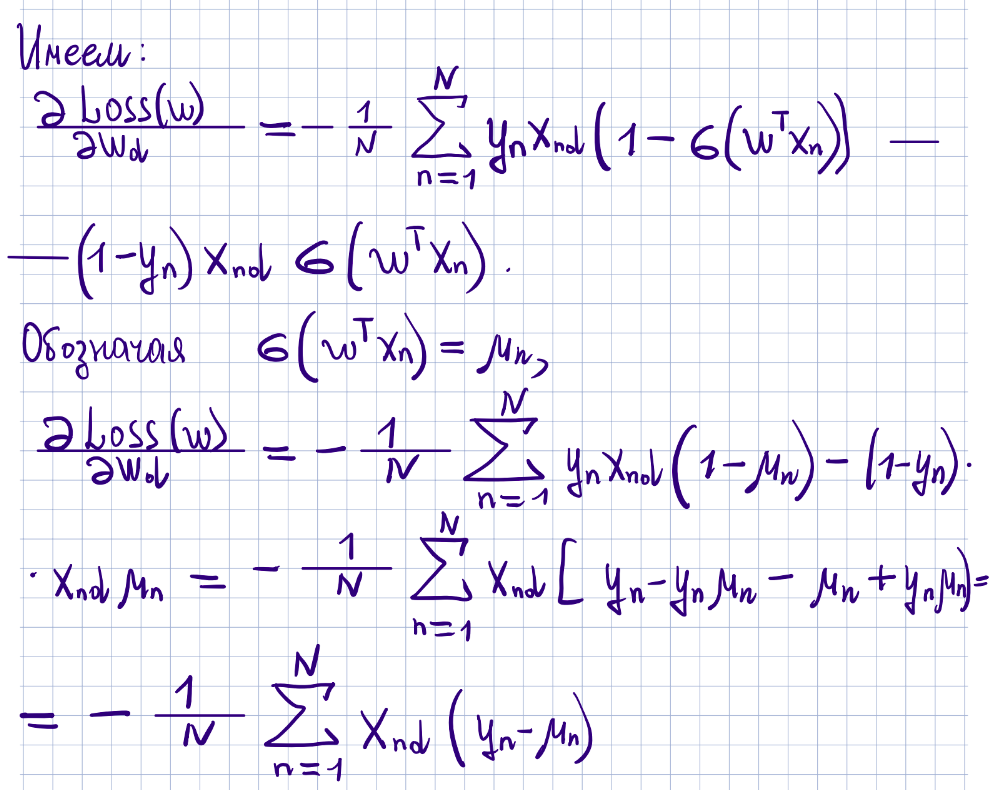

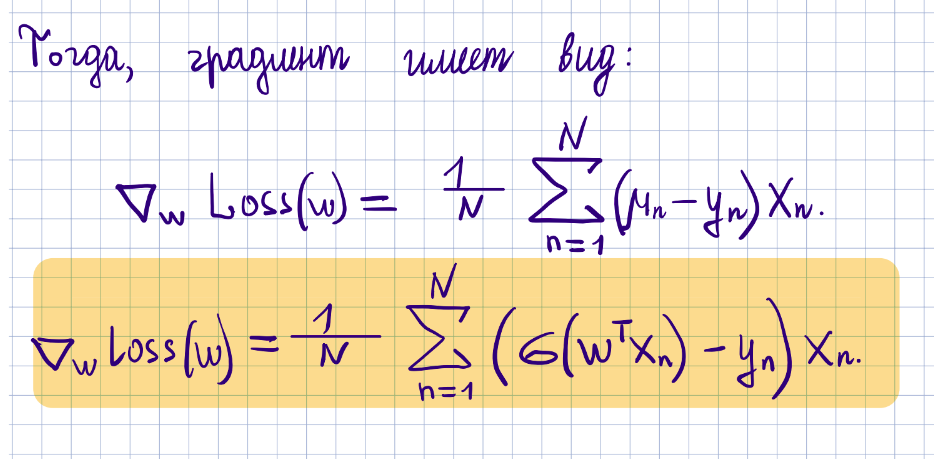

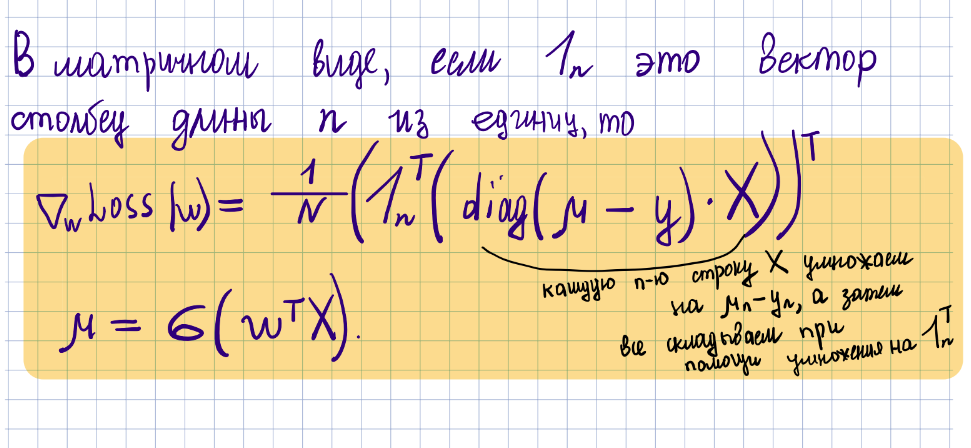

#### Задание №2. Напишите собственную логистическую регрессию

In [5]:
class MyLogRegression():
    def __init__(self, learning_rate = 0.001, eps = 0.0001, n_iter = 10000):
        self.learning_rate = learning_rate
        self.eps = eps
        self.n_iter = n_iter
    
    def __logistic_summary_loss_gradient_with_zero_label(self, w, X, y):
        N = len(X) #quantity of objects
        diag = np.diag(self.__sigmoid(X @ w) - y) #mu minus y
        w_d = diag @ X
        ones = np.ones(N) 
        return 1/N*(ones @ w_d)
        
    def __logistic_summary_loss_gradient_with_negative_label(self, w, X, y):
        y_column = y[..., np.newaxis]
        sigmoid_arg = y_column * X @ w
        sigmoid_arg = sigmoid_arg.astype(float)
        sigmoid_value = (1/(1+np.exp(sigmoid_arg)))[..., np.newaxis]
        return np.sum(-y_column * X * sigmoid_value, axis = 0)
    
    def __sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def __find_threshold(self, X, y, metrics = 'accuracy'):
        p = self.predict_proba(X)
        
        interval = np.arange(start = 0.01, stop = 0.99, step = 0.01)
        
        metrics_results = {}
        metrics_results['accuracy'] = {}
        metrics_results['precision'] = {}
        metrics_results['recall'] = {}
        metrics_results['f1'] = {}
        for i, t in enumerate(interval):
            if self.__zero_label:
                y_pred = np.where(p - t >= 0, 1, 0)
            else:
                y_pred = np.sign(p - t)
            metrics_results['accuracy'][t] = sk.metrics.accuracy_score(y, y_pred)
            metrics_results['precision'][t] = sk.metrics.precision_score(y, y_pred, zero_division=0)
            metrics_results['recall'][t] = sk.metrics.recall_score(y, y_pred, zero_division=0)
            metrics_results['f1'][t] = sk.metrics.f1_score(y, y_pred, zero_division=0)
        self.best_threshold = max(metrics_results[metrics], key = metrics_results[metrics].get)
        return self.best_threshold

    
    def fit(self, X, y, X_valid = None, y_valid = None, metrics = 'accuracy'):
        X = np.hstack([np.ones((len(X), 1)), X])
        w_cur = np.zeros(len(X[0]), dtype=int)
        y_values = np.unique(y)
        
        if np.array_equal(np.sort(y_values), [0,1]):
            grad_method = self.__logistic_summary_loss_gradient_with_zero_label
            self.__zero_label = True
        elif np.array_equal(np.sort(y_values), [-1,1]):
            grad_method = self.__logistic_summary_loss_gradient_with_negative_label
            self.__zero_label = False
        else:
            raise ValueError("Can work only with binary classification!")
        
        i = 0
        while True:
            gradient_value = grad_method(w_cur, X, y)
            w_new = w_cur - self.learning_rate * gradient_value
            
            if np.linalg.norm(w_cur - w_new) <= self.eps or i == self.n_iter:
                break
            i += 1
            w_cur = w_new
        self.__w = w_new
        self._coef = w_new
        self._t = 0.5
        
        if X_valid is None:
            self._t =  self.__find_threshold(X[:, 1:], y, metrics)
        else:
            self._t =  self.__find_threshold(X_valid, y_valid, metrics)
        return self
    
    
    
    def predict_proba(self, X):
        z = (np.hstack([np.ones((len(X), 1)), X]) @ self.__w).astype(float)
        return self.__sigmoid(z)
    def predict(self, X):
        if self.__zero_label:
            return np.where(self.predict_proba(X) - self._t >= 0, 1, 0)
        else:
            return np.sign(self.predict_proba(X) - self._t)

#### Задание №3. Сравните свою логистическую регрессию с аналогичной моделью из sklearn на сгенерированном датасете, опираясь на Accuracy. Баллы за задание: 10 - Accuracy > 99, 5 - Accuracy > 85, 0 - иначе

In [6]:
model = MyLogRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
sk.metrics.accuracy_score(y_test, y_pred)

1.0

In [8]:
model_sklearn = LogisticRegression().fit(X_train, y_train)
y_pred_sklearn = model_sklearn.predict(X_test)

In [9]:
sk.metrics.accuracy_score(y_test, y_pred_sklearn)

1.0

Таким образом, реализованная мной модель логистической регрессии на этих данных отрабатывает с Accuracy более $0.99$.